In [1]:
# CÉLULA 1: Carregar bibliotecas e artefactos

import pandas as pd
import numpy as np
import joblib
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import seaborn as sns

# Configurações de plotagem
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (15, 7)

# --- Carregar o Modelo e o Scaler ---
try:
    model = load_model('../models/oracle_lstm_v1.h5')
    scaler = joblib.load('../models/scaler_v1.pkl')
    print("Modelo e Scaler carregados com sucesso!")
except Exception as e:
    print(f"Erro ao carregar os ficheiros: {e}")

# --- Carregar os dados de teste ---
# (Vamos recriá-los aqui para garantir que o notebook é independente)
df_final = pd.read_feather('../data/processed/final_btc_features.feather')
y = df_final['label']
X = df_final.drop(columns=['label', 'open', 'high', 'low', 'close'])

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

def create_sequences(X, y, time_steps=60):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

TIME_STEPS = 60
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test.values, TIME_STEPS)

# Ajustar labels para o formato do TensorFlow (0, 1, 2)
y_test_adj = y_test_seq + 1

print("\\nDados de teste preparados com sucesso.")
print(f"Shape de X_test_seq: {X_test_seq.shape}")


2025-09-20 15:16:19.334281: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-09-20 15:16:19.334396: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-09-20 15:16:19.334402: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-09-20 15:16:19.334814: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-09-20 15:16:19.334823: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Modelo e Scaler carregados com sucesso!
\nDados de teste preparados com sucesso.
Shape de X_test_seq: (296, 60, 13)


In [2]:
# CÉLULA 2: Gerar previsões para o conjunto de teste

# Fazer as previsões
predictions_test = model.predict(X_test_seq)

# Obter a classe prevista (0, 1 ou 2) para cada dia, pegando o índice da maior probabilidade
predicted_labels = np.argmax(predictions_test, axis=1)

# Ajustar de volta para o nosso formato original (-1, 0, 1)
predicted_signals = predicted_labels - 1

print("Previsões geradas para todo o conjunto de teste.")
print("Exemplo das 10 primeiras previsões:", predicted_signals[:10])


 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step

2025-09-20 15:16:46.702997: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Previsões geradas para todo o conjunto de teste.
Exemplo das 10 primeiras previsões: [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


In [3]:
# CÉLULA 3: Criar o dataframe para o backtest

# Precisamos dos preços de fecho reais que correspondem às nossas previsões.
# O conjunto de teste começa após o fim do conjunto de treino, e temos de descontar os TIME_STEPS.
start_index = len(X_train) + TIME_STEPS
test_prices = df_final['close'].iloc[start_index:]

# Criar o dataframe de backtest
backtest_df = pd.DataFrame({
    'close_price': test_prices,
    'predicted_signal': predicted_signals
}, index=test_prices.index)

# Calcular os retornos diários reais do mercado
backtest_df['market_return'] = backtest_df['close_price'].pct_change()

# Calcular os retornos da nossa estratégia
# A nossa posição no dia seguinte (shift(1)) é baseada no sinal de hoje.
backtest_df['strategy_return'] = backtest_df['market_return'] * backtest_df['predicted_signal'].shift(1)

print("Dataframe de backtest criado:")
display(backtest_df.head())


Dataframe de backtest criado:


,close_price,predicted_signal,market_return,strategy_return
date,,,,
2024-11-17 00:00:00+00:00,89855.99,-1,NaN,NaN
2024-11-18 00:00:00+00:00,90464.08,-1,0.006767,-0.006767
2024-11-19 00:00:00+00:00,92310.79,-1,0.020414,-0.020414
2024-11-20 00:00:00+00:00,94286.56,-1,0.021403,-0.021403
2024-11-21 00:00:00+00:00,98317.12,-1,0.042748,-0.042748


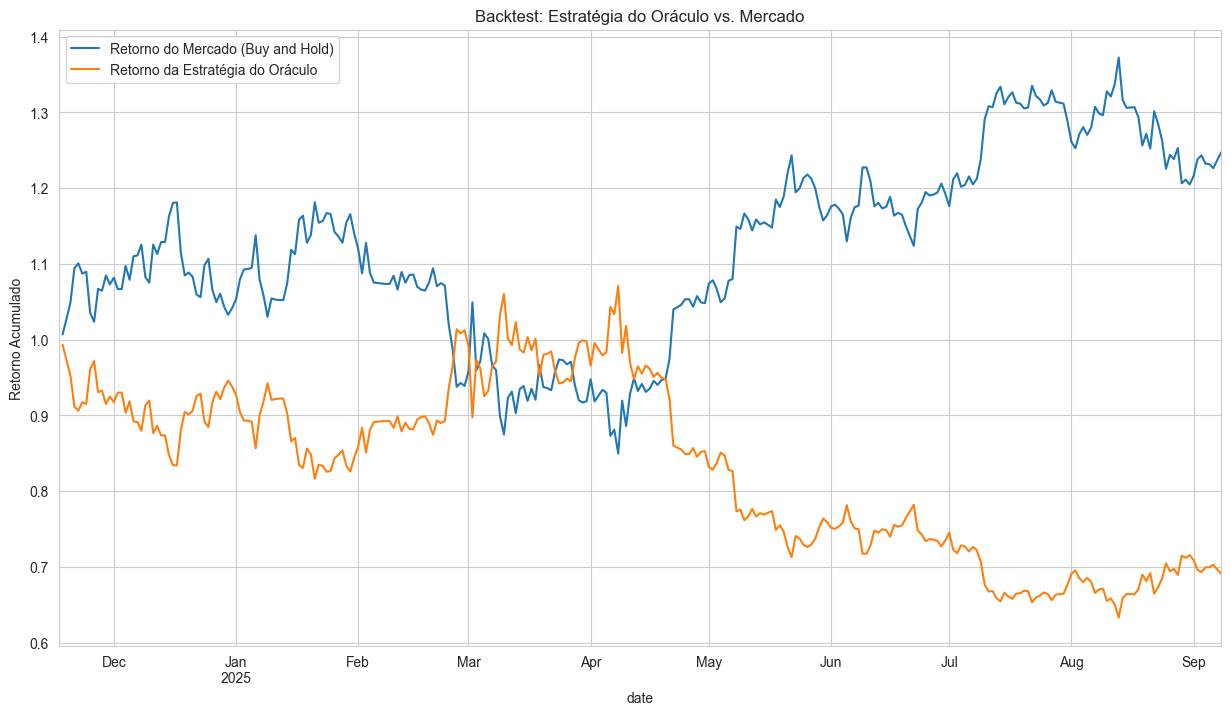

\n--- Resultados Finais do Backtest ---
Retorno Total do Mercado (Buy and Hold): 24.72%
Retorno Total da Estratégia do Oráculo: -30.93%


In [4]:
# CÉLULA 4: Calcular e plotar os retornos acumulados

# Calcular o retorno acumulado (crescimento do capital)
backtest_df['cumulative_market_return'] = (1 + backtest_df['market_return']).cumprod()
backtest_df['cumulative_strategy_return'] = (1 + backtest_df['strategy_return']).cumprod()

# Plotar os resultados
plt.figure(figsize=(15, 8))
backtest_df['cumulative_market_return'].plot(label='Retorno do Mercado (Buy and Hold)')
backtest_df['cumulative_strategy_return'].plot(label='Retorno da Estratégia do Oráculo')
plt.title('Backtest: Estratégia do Oráculo vs. Mercado')
plt.ylabel('Retorno Acumulado')
plt.legend()
plt.show()

# Calcular o retorno total
total_market_return = (backtest_df['cumulative_market_return'].iloc[-1] - 1) * 100
total_strategy_return = (backtest_df['cumulative_strategy_return'].iloc[-1] - 1) * 100

print(f"\\n--- Resultados Finais do Backtest ---")
print(f"Retorno Total do Mercado (Buy and Hold): {total_market_return:.2f}%")
print(f"Retorno Total da Estratégia do Oráculo: {total_strategy_return:.2f}%")


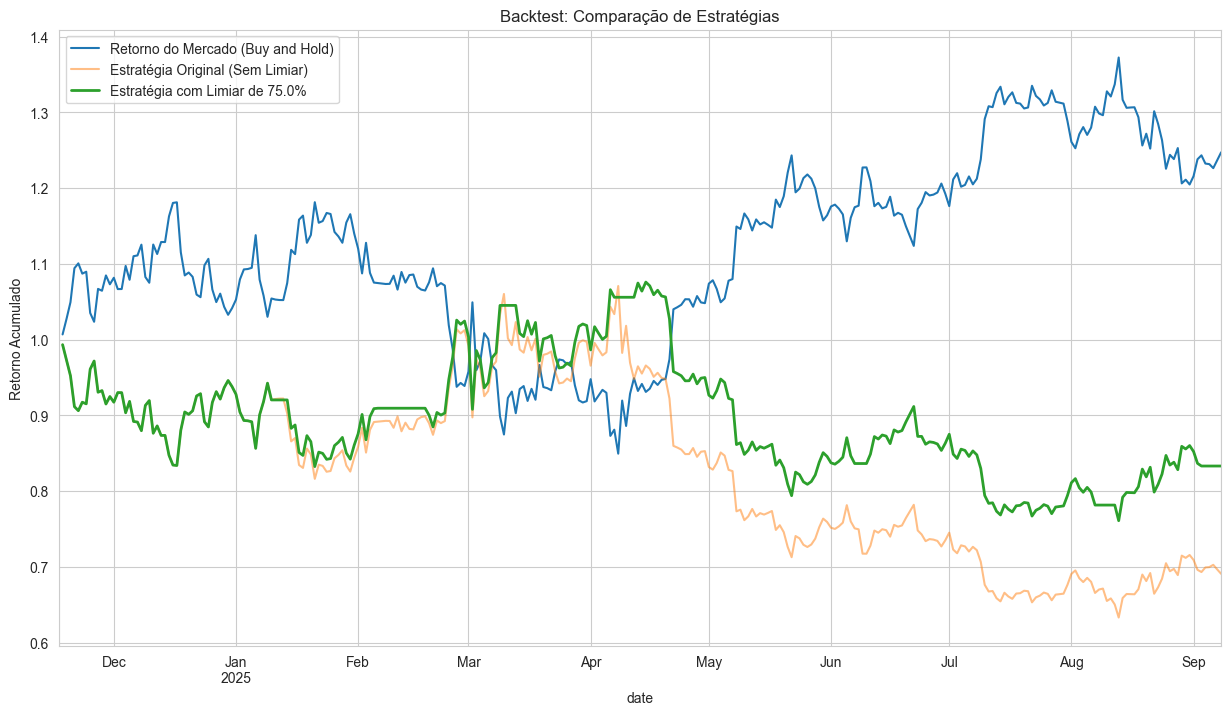

\n--- Resultados da Estratégia com Limiar de Confiança ---
Retorno Total do Mercado (Buy and Hold): 24.72%
Retorno Total da Estratégia com Limiar: -16.69%


In [5]:
# CÉLULA 5: Backtest com Limiar de Confiança

# Definir o nosso limiar de confiança
CONFIDENCE_THRESHOLD = 0.75

# Criar uma nova coluna para os sinais com limiar
backtest_df['confident_signal'] = 0 # Começar com todos os sinais como Neutro (0)

# Obter as probabilidades de cada classe
prob_venda = predictions_test[:, 0]
prob_neutro = predictions_test[:, 1]
prob_compra = predictions_test[:, 2]

# Aplicar a lógica do limiar
# Sinal de Compra (1) se a prob_compra for > threshold
backtest_df.loc[prob_compra > CONFIDENCE_THRESHOLD, 'confident_signal'] = 1

# Sinal de Venda (-1) se a prob_venda for > threshold
backtest_df.loc[prob_venda > CONFIDENCE_THRESHOLD, 'confident_signal'] = -1


# --- Simulação com os novos sinais ---
backtest_df['confident_strategy_return'] = backtest_df['market_return'] * backtest_df['confident_signal'].shift(1)

# Calcular o retorno acumulado
backtest_df['cumulative_confident_strategy'] = (1 + backtest_df['confident_strategy_return']).cumprod()


# --- Plotar o novo resultado ---
plt.figure(figsize=(15, 8))
backtest_df['cumulative_market_return'].plot(label='Retorno do Mercado (Buy and Hold)')
backtest_df['cumulative_strategy_return'].plot(label='Estratégia Original (Sem Limiar)', alpha=0.5)
backtest_df['cumulative_confident_strategy'].plot(label=f'Estratégia com Limiar de {CONFIDENCE_THRESHOLD*100}%', linewidth=2)
plt.title('Backtest: Comparação de Estratégias')
plt.ylabel('Retorno Acumulado')
plt.legend()
plt.show()

# Calcular o retorno total da nova estratégia
total_confident_strategy_return = (backtest_df['cumulative_confident_strategy'].iloc[-1] - 1) * 100

print(f"\\n--- Resultados da Estratégia com Limiar de Confiança ---")
print(f"Retorno Total do Mercado (Buy and Hold): {total_market_return:.2f}%")
print(f"Retorno Total da Estratégia com Limiar: {total_confident_strategy_return:.2f}%")
